<a href="https://colab.research.google.com/github/deepshikha04yadav/Traffic-Gesture-Detection-for-Automotive/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics mediapipe opencv-python-headless torch torchvision torchaudio kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 57.1 MB/s eta 0:00:00

In [ ]:
!pip install kagglehub

In [ ]:
!pip install torch torchvision torchaudio opencv-python matplotlib tqdm kagglehub

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled p

In [1]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("abhishekdhakad8055/traffic-police-gesture-dataset")
print("Dataset path:", path)


100%|██████████| 116M/116M [00:01<00:00, 109MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/abhishekdhakad8055/traffic-police-gesture-dataset/versions/1


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
import random
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the training data
data_dir = os.path.join(path, "Traffic Police Gesture dataset", "Traffic police gesture", "Train")
print("Using dataset from:", data_dir)

Using dataset from: /root/.cache/kagglehub/datasets/abhishekdhakad8055/traffic-police-gesture-dataset/versions/1/Traffic Police Gesture dataset/Traffic police gesture/Train


In [ ]:
class GestureSequenceDataset(Dataset):
    def __init__(self, root_dir, seq_len=3, transform=None):
        self.root_dir = root_dir
        self.seq_len = seq_len
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        for label, cls in enumerate(self.classes):
            folder = os.path.join(root_dir, cls)
            for img in os.listdir(folder):
                self.image_paths.append((os.path.join(folder, img), label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        cls_folder = os.path.dirname(img_path)
        all_imgs = os.listdir(cls_folder)
        # Pick random seq_len images from same class
        seq_imgs = random.sample(all_imgs, min(self.seq_len, len(all_imgs)))

        images = []
        for img_name in seq_imgs:
            img = datasets.folder.default_loader(os.path.join(cls_folder, img_name))
            if self.transform:
                img = self.transform(img)
            images.append(img)
        images = torch.stack(images)  # (seq_len, C, H, W)
        return images, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = GestureSequenceDataset(data_dir, seq_len=3, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

print("Classes:", dataset.classes)


Classes: ['lane left', 'lane right', 'left', 'left over', 'left turn 1', 'move straight', 'right', 'right over', 'right turn', 'stop signal']


In [ ]:
resnet = models.resnet18(pretrained=True)
cnn = nn.Sequential(*list(resnet.children())[:-1])  # remove final FC
for p in cnn.parameters():
    p.requires_grad = False  # freeze CNN

class CNN_LSTM(nn.Module):
    def __init__(self, cnn, hidden_size, num_classes):
        super(CNN_LSTM, self).__init__()
        self.cnn = cnn
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, 3, 224, 224)
        b, s, c, h, w = x.size()
        x = x.view(b * s, c, h, w)
        feats = self.cnn(x).view(b, s, -1)
        _, (h_n, _) = self.lstm(feats)
        out = self.fc(h_n[-1])
        return out


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


In [ ]:
num_classes = len(dataset.classes)
model = CNN_LSTM(cnn, hidden_size=256, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(2):  # demo
    model.train()
    running_loss = 0.0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/2] - Loss: {running_loss/len(dataloader):.4f}")


Epoch [1/2] - Loss: 2.1578
Epoch [2/2] - Loss: 1.5514


In [ ]:
model.eval()
with torch.no_grad():
    imgs, label = dataset[0]
    imgs = imgs.unsqueeze(0).to(device)
    output = model(imgs)
    pred = torch.argmax(output, dim=1).item()
    print(f"True: {dataset.classes[label]}, Predicted: {dataset.classes[pred]}")


True: lane left, Predicted: lane left


In [ ]:
import kagglehub
path = kagglehub.dataset_download("abhishekdhakad8055/traffic-police-gesture-dataset")
print("Dataset path:", path)


100%|██████████| 116M/116M [00:06<00:00, 18.3MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/abhishekdhakad8055/traffic-police-gesture-dataset/versions/1


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dir = os.path.join(path, "Traffic Police Gesture dataset/Traffic police gesture/Train")
test_dir  = os.path.join(path, "Traffic Police Gesture dataset/Traffic police gesture/Test")

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


Classes: ['lane left', 'lane right', 'left', 'left over', 'left turn 1', 'move straight', 'right', 'right over', 'right turn', 'stop signal']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model
resnet = models.resnet50(weights="IMAGENET1K_V1")

# Freeze all layers initially
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze last block (layer4) and fc
for param in resnet.layer4.parameters():
    param.requires_grad = True

in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

resnet = resnet.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-4, weight_decay=1e-4)

In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {acc:.2f}%")

        # Evaluation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = outputs.max(1)
                val_correct += preds.eq(labels).sum().item()
                val_total += labels.size(0)
        val_acc = 100 * val_correct / val_total
        print(f"Validation Acc: {val_acc:.2f}%\n")

train_model(resnet, train_loader, test_loader, criterion, optimizer, epochs=10)


Epoch 1/10: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Train Loss: 1.7836 | Train Acc: 38.90%
Validation Acc: 56.00%



Epoch 2/10: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


Train Loss: 0.9133 | Train Acc: 64.90%
Validation Acc: 63.00%



Epoch 3/10: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


Train Loss: 0.6402 | Train Acc: 75.30%
Validation Acc: 88.00%



Epoch 4/10: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Train Loss: 0.5135 | Train Acc: 79.90%
Validation Acc: 89.00%



Epoch 5/10: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Train Loss: 0.4270 | Train Acc: 82.90%
Validation Acc: 80.50%



Epoch 6/10: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Train Loss: 0.4157 | Train Acc: 83.20%
Validation Acc: 93.50%



Epoch 7/10: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]


Train Loss: 0.3280 | Train Acc: 88.00%
Validation Acc: 91.50%



Epoch 8/10: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


Train Loss: 0.3349 | Train Acc: 87.50%
Validation Acc: 87.50%



Epoch 9/10: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Train Loss: 0.2665 | Train Acc: 90.20%
Validation Acc: 97.00%



Epoch 10/10: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Train Loss: 0.2594 | Train Acc: 90.10%
Validation Acc: 93.00%



In [ ]:
torch.save(resnet.state_dict(), "fine_tuned_gesture_resnet50.pth")
print("Model saved successfully ✅")

Model saved successfully ✅


In [ ]:
# --- Inference Setup ---
import torch
import torch.nn.functional as F
import cv2, base64
import numpy as np
from IPython.display import display, Javascript
from google.colab.output import eval_js
from PIL import Image
from torchvision import transforms
import mediapipe as mp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate model & load weights
from torchvision import models
num_classes = len(train_dataset.classes)
resnet = models.resnet50(weights=None)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load("fine_tuned_gesture_resnet50.pth", map_location=device))
resnet = resnet.to(device)
resnet.eval()

classes = train_dataset.classes
confidence_threshold = 0.6

# --- Image preprocessing (must match training) ---
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# --- Webcam capture ---
def take_photo(filename='gesture.jpg', quality=0.8):
    js = Javascript('''
        (async function() {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = '📸 Capture Photo';
          capture.style.fontSize = '20px';
          div.appendChild(capture);
          document.body.appendChild(div);

          const video = document.createElement('video');
          video.style.display = 'block';
          video.style.marginTop = '10px';
          document.body.appendChild(video);

          const stream = await navigator.mediaDevices.getUserMedia({video: true});
          video.srcObject = stream;
          await video.play();

          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for button click
          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);

          stream.getVideoTracks()[0].stop();
          div.remove();
          video.remove();

          const dataUrl = canvas.toDataURL('image/jpeg', quality);
          google.colab.kernel.invokeFunction('notebook.takePhoto', [dataUrl], {});
        })();
    ''')

    display(js)

    # Define callback to get data back from JS
    import google.colab.output
    photo_data = {}
    def _callback(data):
        photo_data['data'] = data
    google.colab.output.register_callback('notebook.takePhoto', _callback)

    # Wait until JS sends data
    while 'data' not in photo_data:
        pass

    # Convert base64 → image
    data = photo_data['data']
    import base64, cv2, numpy as np
    binary = np.frombuffer(base64.b64decode(data.split(',')[1]), dtype=np.uint8)
    img = cv2.imdecode(binary, cv2.IMREAD_COLOR)
    cv2.imwrite(filename, img)
    return filename

# --- Mediapipe person detector ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

def detect_person_count(image):
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not results.pose_landmarks:
        return 0
    return 1  # single person detected (for now)

# --- Prediction helper ---
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = resnet(tensor)
        probs = F.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)
    return conf.item(), classes[pred.item()]

# --- Run webcam inference ---
try:
    image_path = take_photo('gesture.jpg')
    img_cv = cv2.imread(image_path)

    person_count = detect_person_count(img_cv)
    if person_count != 1:
        print("⚠️ Multiple or no person detected — no gesture classified.")
    else:
        conf, gesture = predict_image(image_path)
        if conf < confidence_threshold:
            print("⚠️ Unknown / No Gesture Detected (low confidence)")
        else:
            print(f"✅ Detected Gesture: {gesture} ({conf*100:.1f}% confidence)")
except Exception as e:
    print("Error:", e)


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Dataset directory structure:
# /root/.cache/kagglehub/datasets/abhishekdhakad8055/traffic-police-gesture-dataset/versions/1/Traffic Police Gesture dataset/Train/
data_dir = "/root/.cache/kagglehub/datasets/abhishekdhakad8055/traffic-police-gesture-dataset/versions/1/Traffic Police Gesture dataset/Train/"

# Image preprocessing and data augmentation
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,       # 20% of data for validation
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# CNN Model Definition
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
epochs = 20
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# # Save the model
# model.save('gesture_cnn_model.h5')


Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 659ms/step - accuracy: 0.1015 - loss: 2.5931 - val_accuracy: 0.1650 - val_loss: 2.3026
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 559ms/step - accuracy: 0.1135 - loss: 2.3032 - val_accuracy: 0.1050 - val_loss: 2.3022
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 538ms/step - accuracy: 0.1204 - loss: 2.3025 - val_accuracy: 0.0950 - val_loss: 2.2982
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - accuracy: 0.1118 - loss: 2.2932 - val_accuracy: 0.1100 - val_loss: 2.3015
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step - accuracy: 0.1052 - loss: 2.3005 - val_accuracy: 0.1300 - val_loss: 2.2984
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 527ms/step - accuracy: 0.1221 - loss: 2.2867 - val_accuracy: 0.1150 - val_loss: 2.2867
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 522ms/step - accuracy: 0.1302 - loss: 2.2788 - val_accuracy: 0.1050 - val_loss: 2.2542
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 554ms/step - accuracy: 0.1363 - loss: 2.2619 - val_accu

In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base layers initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Unfreeze some layers and fine-tune:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.0953 - loss: 2.7961 - val_accuracy: 0.1150 - val_loss: 2.2965
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 535ms/step - accuracy: 0.1604 - loss: 2.2565 - val_accuracy: 0.1150 - val_loss: 2.2361
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 548ms/step - accuracy: 0.1809 - loss: 2.2077 - val_accuracy: 0.2400 - val_loss: 2.2139
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 540ms/step - accuracy: 0.2163 - loss: 2.1445 - val_accuracy: 0.2250 - val_loss: 2.1443
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 545ms/step - accuracy: 0.2541 - loss: 2.0640 - val_accuracy: 0.2850 - val_loss: 2.0825
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step - accuracy: 0.2714 - loss: 1.9674 - val_accuracy: 0.3050 - val_loss: 1.9940
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 530ms/step - accuracy: 0.2990 - loss: 1.9230 - val_accuracy: 0.3300 - val_loss: 1.9647
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/ste

In [4]:
model.save('gesture_cnn_model.keras')

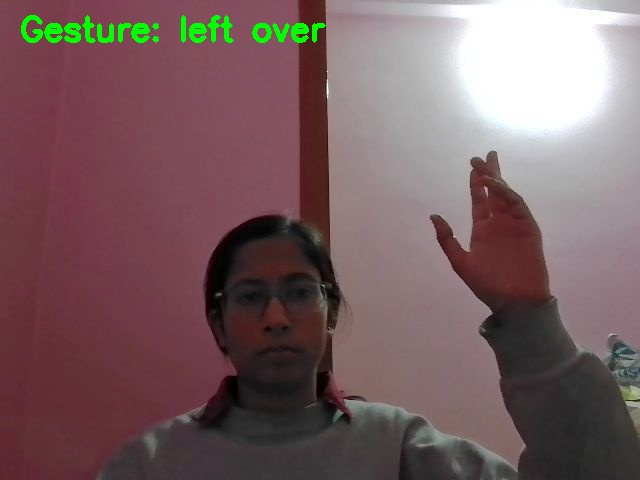

MessageError: ReferenceError: captureFrame is not defined

In [26]:
# 1. Setup: Import libraries
import cv2
import numpy as np
import tensorflow as tf
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import display, Javascript, Image, clear_output

# Load your trained model (.h5 or .keras)
model = tf.keras.models.load_model('gesture_cnn_model.keras')

# Update with your actual class labels (folder order)
class_labels = [
    'lane left', 'lane right', 'left', 'left over',
    'left turn 1', 'move straight', 'right',
    'right over', 'right turn', 'stop signal'
]
img_height, img_width = 224, 224

# 2. JS webcam capture function
from IPython.display import display, Javascript

js = Javascript('''
async function captureFrame() {
  const video = document.createElement('video');
  video.style.display = 'block';
  document.body.appendChild(video);
  const stream = await navigator.mediaDevices.getUserMedia({video: true});
  video.srcObject = stream;
  await video.play();
  await new Promise(resolve => setTimeout(resolve, 1000)); // Ensure video is ready

  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth;
  canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  const dataURL = canvas.toDataURL('image/jpeg', 0.8);

  stream.getTracks().forEach(track => track.stop());
  video.remove();

  return dataURL;
}
''')
display(js)


# 3. Python helper to get webcam frame
def get_webcam_frame():
    data = eval_js("captureFrame()")
    img_bytes = b64decode(data.split(',')[1])
    img_array = np.frombuffer(img_bytes, dtype=np.uint8)
    frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return frame

# 4. Run live prediction loop
from time import sleep
print("Starting webcam for gesture recognition...")
for i in range(200):  # Capture up to 200 frames
    frame = get_webcam_frame()
    img_resized = cv2.resize(frame, (img_width, img_height))
    img_normalized = img_resized.astype('float32') / 255.0
    input_tensor = np.expand_dims(img_normalized, axis=0)

    preds = model.predict(input_tensor, verbose=0)
    pred_label = class_labels[np.argmax(preds)]

    # Overlay prediction on frame
    cv2.putText(frame, f'Gesture: {pred_label}', (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,255,0), 3)

    # Convert frame to displayable image
    _, jpeg = cv2.imencode('.jpg', frame)
    clear_output(wait=True)
    display(Image(data=jpeg.tobytes()))
    sleep(0.25)  # Avoid rapid refresh, adjust if needed

print("Webcam session ended.")
